# Lab6 - WordNet

In [1]:
import requests as r
from functional import seq
from functional.streams import Sequence
from collections import namedtuple
from typing import Dict,List,Tuple, Optional,Set
from functools import lru_cache
import matplotlib.pyplot as plt
import numpy as np
import math
from fn import _
base ="http://api.slowosiec.clarin-pl.eu/plwordnet-api"

In [2]:
%matplotlib inline

## 1. Read the [Wordnet API](http://api.slowosiec.clarin-pl.eu/docs/index.html)



## 2\. Get acquainted with [semantic relations](http://nlp.pwr.wroc.pl/narzedzia-i-zasoby/narzedzia/disaster/25-wiedza/81-relacje-w-slowosieci) in WordNet.

Nouns
 - hypernyms:
     - supersets of sth - animal is hypernym of dog
     - Y is a hypernym of X if every X is a (kind of) Y (canine is a hypernym of dog)
 - hyponyms:
     - subsets
     - Y is a hyponym of X if every Y is a (kind of) X (dog is a hyponym of canine)
 - coordinate terms:
     - siblings
     - Y is a coordinate term of X if X and Y share a hypernym (wolf is a coordinate term of dog, and dog is a coordinate term of wolf)
 - meronym:
     - being a part of
     - Y is a meronym of X if Y is a part of X (window is a meronym of building)
 - holonym:
     - being a whole thing (...)
     - Y is a holonym of X if X is a part of Y (building is a holonym of window)
     
     
Verbs
  - hypernym: 
      - supersets
      - the verb Y is a hypernym of the verb X if the activity X is a (kind of) Y (to perceive is an hypernym of to listen)
   - troponym:
       - doing sth else is to some degree (?)
       - the verb Y is a troponym of the verb X if the activity Y is doing X in some manner (to lisp is a troponym of to talk)
  - entailment:
        - the verb Y is entailed by X if by doing X you must be doing Y (to sleep is entailed by to snore)
  - coordinate terms:
      - siblings
      - those verbs sharing a common hypernym (to lisp and to yell)

## 3\. Find all meaning of the _szkoda_ **noun** and display all their synonyms.

In [3]:
def senses_search(word):
    return seq(r.get(base + "/senses/search",{"lemma":word}).json()['content'])

In [4]:
json = senses_search("szkoda")

In [5]:
json[0]

{'domain': {'description': 'plWN miejsca i umiejscowienie',
  'id': 12,
  'lexicon': {'id': 1,
   'language': 'pl',
   'lexiconIdentifier': 'P 2.2',
   'name': 'Słowosieć 2.2'},
  'name': 'plWN_msc'},
 'id': 8769,
 'lemma': {'id': 249489, 'word': 'szkoda'},
 'lexicon': {'id': 1,
  'language': 'pl',
  'lexiconIdentifier': 'P 2.2',
  'name': 'Słowosieć 2.2'},
 'partOfSpeech': {'id': 2,
  'lexicon': {'id': 1,
   'language': 'pl',
   'lexiconIdentifier': 'P 2.2',
   'name': 'Słowosieć 2.2'},
  'lmfType': 'noun',
  'name': 'plWN rzeczownik'},
 'senseNumber': 1}

In [6]:
def trim_sense(field:Dict):
    return {
        'lemma':field['lemma']['word'],
        'id':field['id'],
        "domain":field['domain']['description'],
        'partOfSpeech': field['partOfSpeech']['lmfType'],
        'sense' : field['senseNumber']
    }

In [7]:
entries = seq(json).map(trim_sense)
entries

szkoda,8769,plWN miejsca i umiejscowienie,noun,1
szkoda,8770,plWN czasowniki wyrażające uczucia,verb,1
szkoda,8771,plWN posiadanie i jego zmiana,noun,2


In [8]:
@lru_cache()
def synsetid_for_sense(senseid):
    return r.get(base+ "/senses/{}/synset".format(senseid)).json()['id']

@lru_cache()
def synset_by_id(synsetid):
    return r.get(base+ "/synsets/{}/senses".format(synsetid)).json()



def synonyms(senseid): 
    return seq(synset_by_id(synsetid_for_sense(senseid))).map(trim_sense)

In [9]:
synonyms(8769)

szkoda,8769,plWN miejsca i umiejscowienie,noun,1


In [10]:
synonyms(8770)

szkoda,8770,plWN czasowniki wyrażające uczucia,verb,1
żałować,11379,plWN czasowniki wyrażające uczucia,verb,3
żal,143137,plWN czasowniki wyrażające uczucia,verb,1


In [11]:
synonyms(8771)

strata,8495,plWN zdarzenia,noun,1
utrata,9582,plWN zdarzenia,noun,1
szkoda,8771,plWN posiadanie i jego zmiana,noun,2
uszczerbek,29762,plWN zdarzenia,noun,1


## 4\. Find closure of **hypernymy** relation for the first meaning of the _wypadek drogowy_ expression.
   Create diagram of the relations as a directed graph.
   

In [12]:
#find hypernyme relation id
RelationType= namedtuple("RelationType","id, name")
def relationTypes():
    return seq(r.get(base+ "/relationTypes").json()).map(lambda entry: RelationType(id=entry['id'],name= entry['name']))
relationTypes()

id,name
10,hiponimia
11,hiperonimia
12,antonimia
13,konwersja
14,meronimia
15,holonimia
19,fuzzynimia
20,część
21,porcja
22,miejsce


In [13]:
hyperonymy_id = 11

In [14]:
wypadek_drogowy_sense=senses_search("wypadek drogowy").map(trim_sense).head()
wypadek_drogowy_sense

{'domain': 'plWN zdarzenia',
 'id': 644786,
 'lemma': 'wypadek drogowy',
 'partOfSpeech': 'noun',
 'sense': 1}

In [15]:
wypadek_syn= synsetid_for_sense(wypadek_drogowy_sense['id'])
print(wypadek_syn)

@lru_cache()
def synset_rel(synset,rel):
    body = r.get(base+"/synsets/{}/relations".format(synset)).json()
    return seq(body).find(lambda x: x['relation']['id']==rel and x['synsetFrom']['id']!= synset)

def get_synset_from(relation_dict):
    return  relation_dict['synsetFrom']['id']
   
    
def synsets_to_the_top(acc,rel):
    print(acc)
    new_rel = synset_rel(acc[-1],rel)
    if new_rel is None:
        return acc
    else:
        new_synset= get_synset_from(new_rel)
        acc.append(new_synset)
        return synsets_to_the_top(acc,rel)

410902


In [16]:
synset_rel(410901,11)

{'id': 27975,
 'relation': {'autoReverse': True,
  'description': 'Hipo-/hiperonimia to podstawowa relacja kształtująca hierarchiczną strukturę słownictwa.Jest to relacja, którą można określić jako implikację jednostronną. Hiperonimia jest relacją między jednostkami należącymi do tej samej klasy fleksyjnej.',
  'displayText': '<x#> jest hiperonimem <y#>',
  'id': 11,
  'lexicon': {'id': 1,
   'language': 'pl',
   'lexiconIdentifier': 'P 2.2',
   'name': 'Słowosieć 2.2'},
  'multilingual': False,
  'name': 'hiperonimia',
  'shortDisplayText': 'hiper'},
 'synsetFrom': {'id': 3982, 'split': 1},
 'synsetTo': {'id': 410901, 'split': 1}}

In [17]:
wypadek_hyp_closure =(synsets_to_the_top([wypadek_syn],hyperonymy_id))

[410902]
[410902, 410901]
[410902, 410901, 3982]
[410902, 410901, 3982, 27419]
[410902, 410901, 3982, 27419, 6526]


In [18]:
closure_senses = seq(wypadek_hyp_closure)\
.map(synset_by_id)\
.map(lambda senses:
     seq(senses).map(lambda sense:sense['lemma']['word'])
    )
closure_senses

wypadek drogowy,,,
wypadek komunikacyjny,,,
wypadek,,,
zdarzenie oceniane negatywnie,,,
wydarzenie,historia,wypadek,zdarzenie


In [19]:
closure_senses.head()

['wypadek drogowy']

In [20]:
import networkx as nx
def draw_graph_line(G):
    fig = plt.figure()
    fig.set_size_inches(14,14)
    pos = nx.layout.kamada_kawai_layout(G)
    nx.draw(G,pos=pos)
    nx.draw_networkx_labels(G,pos=pos)
    plt.show()

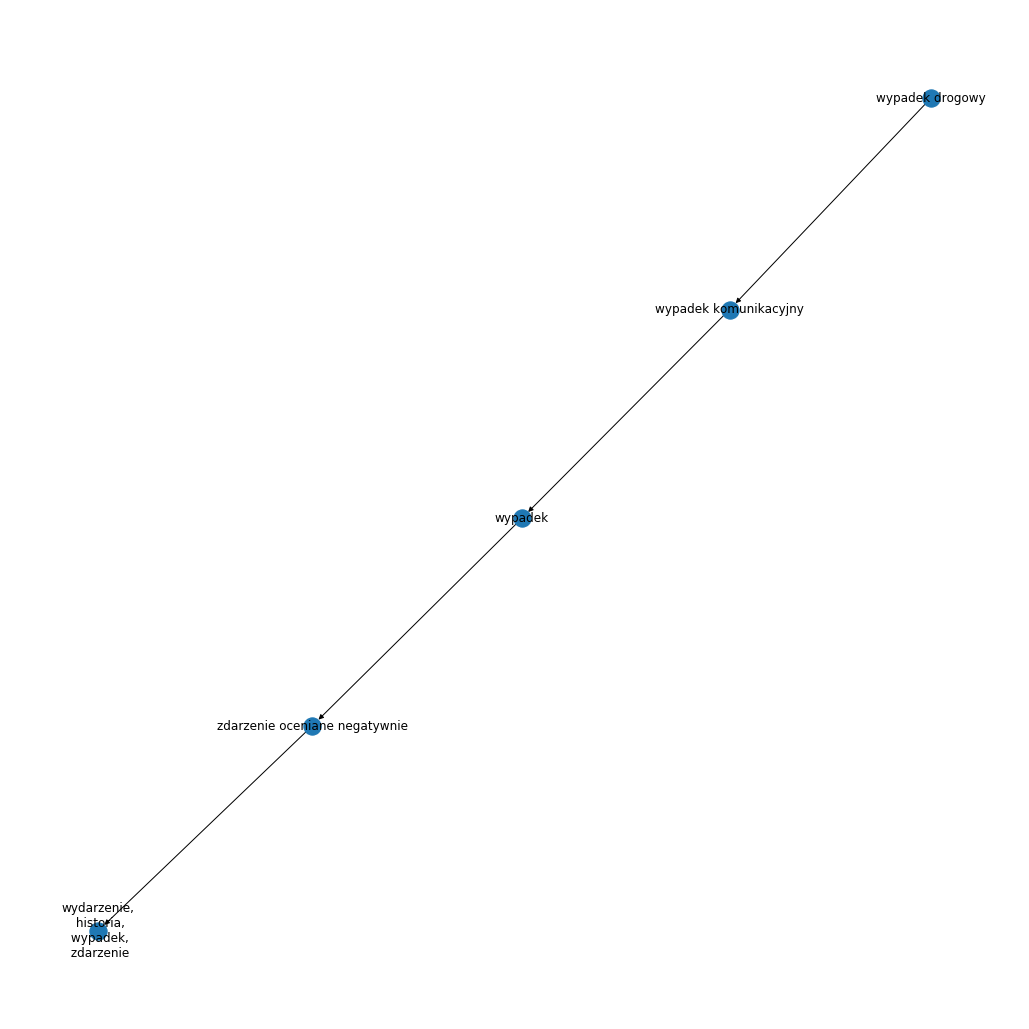

In [21]:
synsets_strings = closure_senses.map(lambda words: seq(words).reduce(lambda x,y : x+",\n "+y))

nodeids = seq(range(0,synsets_strings.size()))
g= nx.DiGraph()
nodeids.for_each(g.add_node)
init = nodeids.init()
tail = nodeids.tail()

init.zip(tail).for_each(lambda x : g.add_edge(x[0],x[1]))


mapping = synsets_strings.zip_with_index().map(lambda x: (x[1],x[0])).to_dict()
h= nx.relabel_nodes(g,mapping)
draw_graph_line(h)

## 5\. Find direct **hyponyms** of _wypadek<sub>1</sub>_ noun.

In [22]:
relationTypes().find(_.id ==10)

RelationType(id=10, name='hiponimia')

In [23]:
senses_search("wypadek")

21890,"{'id': 8, 'name': 'plWN_zdarz', 'description': 'plWN zdarzenia', 'lexicon': {'id': 1, 'name': 'Słowosieć 2.2', 'lexiconIdentifier': 'P 2.2', 'language': 'pl'}}","{'id': 286391, 'word': 'wypadek'}","{'id': 2, 'name': 'plWN rzeczownik', 'lexicon': {'id': 1, 'name': 'Słowosieć 2.2', 'lexiconIdentifier': 'P 2.2', 'language': 'pl'}, 'lmfType': 'noun'}",1,"{'id': 1, 'name': 'Słowosieć 2.2', 'lexiconIdentifier': 'P 2.2', 'language': 'pl'}"
10426,"{'id': 8, 'name': 'plWN_zdarz', 'description': 'plWN zdarzenia', 'lexicon': {'id': 1, 'name': 'Słowosieć 2.2', 'lexiconIdentifier': 'P 2.2', 'language': 'pl'}}","{'id': 286391, 'word': 'wypadek'}","{'id': 2, 'name': 'plWN rzeczownik', 'lexicon': {'id': 1, 'name': 'Słowosieć 2.2', 'lexiconIdentifier': 'P 2.2', 'language': 'pl'}, 'lmfType': 'noun'}",2,"{'id': 1, 'name': 'Słowosieć 2.2', 'lexiconIdentifier': 'P 2.2', 'language': 'pl'}"
69514,"{'id': 8, 'name': 'plWN_zdarz', 'description': 'plWN zdarzenia', 'lexicon': {'id': 1, 'name': 'Słowosieć 2.2', 'lexiconIdentifier': 'P 2.2', 'language': 'pl'}}","{'id': 286391, 'word': 'wypadek'}","{'id': 2, 'name': 'plWN rzeczownik', 'lexicon': {'id': 1, 'name': 'Słowosieć 2.2', 'lexiconIdentifier': 'P 2.2', 'language': 'pl'}, 'lmfType': 'noun'}",3,"{'id': 1, 'name': 'Słowosieć 2.2', 'lexiconIdentifier': 'P 2.2', 'language': 'pl'}"
644786,"{'id': 8, 'name': 'plWN_zdarz', 'description': 'plWN zdarzenia', 'lexicon': {'id': 1, 'name': 'Słowosieć 2.2', 'lexiconIdentifier': 'P 2.2', 'language': 'pl'}}","{'id': 286392, 'word': 'wypadek drogowy'}","{'id': 2, 'name': 'plWN rzeczownik', 'lexicon': {'id': 1, 'name': 'Słowosieć 2.2', 'lexiconIdentifier': 'P 2.2', 'language': 'pl'}, 'lmfType': 'noun'}",1,"{'id': 1, 'name': 'Słowosieć 2.2', 'lexiconIdentifier': 'P 2.2', 'language': 'pl'}"
644778,"{'id': 8, 'name': 'plWN_zdarz', 'description': 'plWN zdarzenia', 'lexicon': {'id': 1, 'name': 'Słowosieć 2.2', 'lexiconIdentifier': 'P 2.2', 'language': 'pl'}}","{'id': 286393, 'word': 'wypadek komunikacyjny'}","{'id': 2, 'name': 'plWN rzeczownik', 'lexicon': {'id': 1, 'name': 'Słowosieć 2.2', 'lexiconIdentifier': 'P 2.2', 'language': 'pl'}, 'lmfType': 'noun'}",1,"{'id': 1, 'name': 'Słowosieć 2.2', 'lexiconIdentifier': 'P 2.2', 'language': 'pl'}"
30231,"{'id': 8, 'name': 'plWN_zdarz', 'description': 'plWN zdarzenia', 'lexicon': {'id': 1, 'name': 'Słowosieć 2.2', 'lexiconIdentifier': 'P 2.2', 'language': 'pl'}}","{'id': 286394, 'word': 'wypadek losowy'}","{'id': 2, 'name': 'plWN rzeczownik', 'lexicon': {'id': 1, 'name': 'Słowosieć 2.2', 'lexiconIdentifier': 'P 2.2', 'language': 'pl'}, 'lmfType': 'noun'}",1,"{'id': 1, 'name': 'Słowosieć 2.2', 'lexiconIdentifier': 'P 2.2', 'language': 'pl'}"
67996,"{'id': 8, 'name': 'plWN_zdarz', 'description': 'plWN zdarzenia', 'lexicon': {'id': 1, 'name': 'Słowosieć 2.2', 'lexiconIdentifier': 'P 2.2', 'language': 'pl'}}","{'id': 286395, 'word': 'wypadek przy pracy'}","{'id': 2, 'name': 'plWN rzeczownik', 'lexicon': {'id': 1, 'name': 'Słowosieć 2.2', 'lexiconIdentifier': 'P 2.2', 'language': 'pl'}, 'lmfType': 'noun'}",1,"{'id': 1, 'name': 'Słowosieć 2.2', 'lexiconIdentifier': 'P 2.2', 'language': 'pl'}"
67995,"{'id': 23, 'name': 'plWN_st', 'description': 'plWN sytuacje statyczne (stany)', 'lexicon': {'id': 1, 'name': 'Słowosieć 2.2', 'lexiconIdentifier': 'P 2.2', 'language': 'pl'}}","{'id': 286395, 'word': 'wypadek przy pracy'}","{'id': 2, 'name': 'plWN rzeczownik', 'lexicon': {'id': 1, 'name': 'Słowosieć 2.2', 'lexiconIdentifier': 'P 2.2', 'language': 'pl'}, 'lmfType': 'noun'}",2,"{'id': 1, 'name': 'Słowosieć 2.2', 'lexiconIdentifier': 'P 2.2', 'language': 'pl'}"


In [24]:
wypadek_sense_ids= seq([21890,10426,69514])
wypadek_synset_ids = wypadek_sense_ids.map(synsetid_for_sense)

def synsetids_for_sysnset_rel(synsetids,rel):
    return synsetids.map(lambda synset: synset_rel(synset,rel))\
    .map(get_synset_from)

def words_for_synsetid_seq(synsetidseq):
    return synsetidseq\
    .map(lambda synsetid: 
         seq(synset_by_id(synsetid)).map(lambda sense: sense['lemma']['word'])
        )
words_for_synsetid_seq(
    synsetids_for_sysnset_rel(
        wypadek_synset_ids,
        10
    )
)

zawał,,
stłuczka,zderzenie,kraksa
zajście,,


## 6\. Find second-order **hyponyms** of the same noun.

In [25]:
first_order = synsetids_for_sysnset_rel(wypadek_synset_ids,10)
second_order = synsetids_for_sysnset_rel(first_order,10)
words_for_synsetid_seq(second_order)

obwał,,,,,,,,,,,
czołówka,zderzenie czołowe,,,,,,,,,,
bójka,bijatyka,bitka,bitwa,łomotanina,mordobicie,nawalanka,przewalanka,rękoczyny,rozpierducha,rozróba,rozróbka


## 7\. Display as a directed graph (with labels for the edges) semantic relations between the following groups of lexemes:

   a) szkoda<sub>2</sub>, strata<sub>1</sub>, uszczerbek<sub>1</sub>, szkoda majątkowa<sub>1</sub>, 
      uszczerbek na zdrowiu<sub>1</sub>, krzywda<sub>1</sub>, niesprawiedliwość<sub>1</sub>, nieszczęście<sub>2</sub>.

In [26]:
LemmaWithIndex=namedtuple("LemmaWithIndex","lemma index")
words = [
    LemmaWithIndex(lemma="szkoda", index=2),
    LemmaWithIndex(lemma="strata", index=1),
    LemmaWithIndex(lemma="uszczerbek", index=1),
#     LemmaWithIndex(lemma="szkoda majątkowa", index=1),  #Cannot find it
    LemmaWithIndex(lemma="uszczerbek na zdrowiu", index=1),
    LemmaWithIndex(lemma="krzywda", index=1),
    LemmaWithIndex(lemma="niesprawiedliwość", index=1),
    LemmaWithIndex(lemma="nieszczęście", index=2)
]


In [27]:
Sense=namedtuple("Sense","lemma id")

In [28]:
def senseid_for_lemma_with_index(lemma:LemmaWithIndex)-> Sense:
    sense = seq(senses_search(lemma.lemma)).find(lambda json: json['senseNumber']== lemma.index)
    if sense is None:
        msg ="Sense not found for {}".format(lemma)
        raise msg
    return Sense(lemma= lemma.lemma, id= sense['id'])
senseid_for_lemma_with_index(words[0])

Sense(lemma='szkoda', id=8771)

In [29]:
senses = seq(words).map(senseid_for_lemma_with_index) # Seq[Sense]
senses

lemma,id
szkoda,8771
strata,8495
uszczerbek,29762
uszczerbek na zdrowiu,67978
krzywda,2967
niesprawiedliwość,4278
nieszczęście,12324


In [30]:
Synset=namedtuple("Synset","example id")
synsets = senses.map(lambda sense: Synset(example = sense, id = synsetid_for_sense(sense.id)))
synset_ids = synsets.map(_.id).distinct()
synsets

example,id
"Sense(lemma='szkoda', id=8771)",3675
"Sense(lemma='strata', id=8495)",3675
"Sense(lemma='uszczerbek', id=29762)",3675
"Sense(lemma='uszczerbek na zdrowiu', id=67978)",46769
"Sense(lemma='krzywda', id=2967)",1439
"Sense(lemma='niesprawiedliwość', id=4278)",1439
"Sense(lemma='nieszczęście', id=12324)",5640


In [31]:
Relation = namedtuple("Relation", "src dst rel_id")
@lru_cache()
def synset_rels(synsetid:int)->Sequence :# [Relation]
    body = r.get(base+"/synsets/{}/relations".format(synsetid)).json()
    return seq(body)\
    .map(lambda x:
         Relation(src=x['synsetFrom']['id'], dst=x['synsetTo']['id'], rel_id = x['relation']['id'])
        )
    
    
def relations_with_selected(synsetid:int, selected): #Seq[Relation]
    not_me = selected.filter_not(_ == synsetid)
    return synset_rels(synsetid).filter(lambda syn: syn.src in not_me or syn.dst in not_me )


relations = synset_ids.flat_map(lambda syn: relations_with_selected(syn,synset_ids)).distinct()

In [32]:
relations

src,dst,rel_id
5640,1439,11
3675,46769,11
1439,3675,10
3675,1439,11
46769,3675,10
1439,5640,10


In [33]:
rel_types=relationTypes().to_dict()

def graph_and_labels(synset_ids,relations,synsets):
    if type(synsets.head())!= Synset:
        raise "Wrong synset type"
    g = nx.DiGraph()
    synset_ids.for_each(g.add_node)
    relations.for_each(lambda rel: g.add_edge(rel.src, rel.dst,rel_id= rel_types[rel.rel_id]))


    mapping = synsets.group_by(_.id)\
    .map(lambda x:
         (x[0],seq(x[1])\
          .map(_.example.lemma)\
          .reduce(lambda x,y: x+ ",\n "+y)
         )
        ).to_dict()

    if synset_ids.to_set() != set(mapping.keys()):
        raise "Ids of mapping don't match"

    h= nx.relabel_nodes(g,mapping)
    labels = nx.get_edge_attributes(h, "rel_id")
    return h,labels

def plot(graph:nx.DiGraph,labels):
    fig = plt.figure()
    fig.set_size_inches(14,14)
    pos = nx.planar_layout(graph)
    nx.draw(graph,pos=pos,with_labels=True,arrows=True,arrowsize=50,node_size=30000)
    nx.draw_networkx_labels(graph,pos=pos)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    plt.show()
    
h,labels = graph_and_labels(synset_ids,relations,synsets)
# plot(h,labels) Prettier but draws straight arro

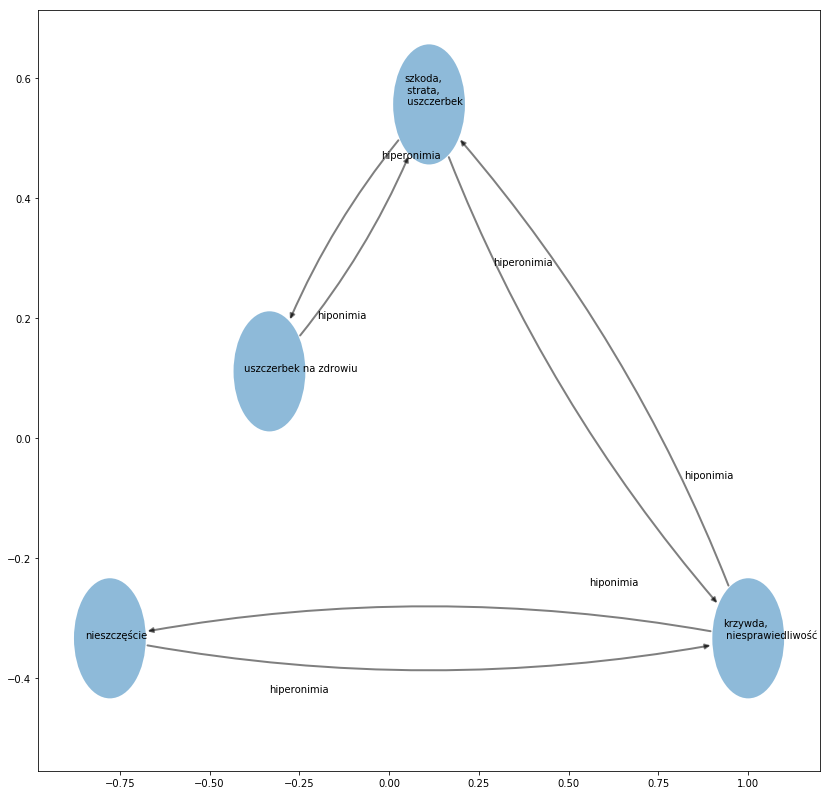

In [34]:
from matplotlib.patches import FancyArrowPatch, Circle
def draw_network(G,pos,ax,labels):
    rad=0.1
    e = None
    for n in G:
        c=Circle(pos[n],radius=0.1,alpha=0.5)
        ax.add_patch(c)
        G.node[n]['patch']=c
        x,y=c.center
        ax.text(x-0.07,y,n)
    seen={}
    for (u,v,d) in G.edges(data=True):
        n1=G.node[u]['patch']
        n2=G.node[v]['patch']
        if (u,v) in seen:
            rad=seen.get((u,v))
            rad=(rad+np.sign(rad)*0.1)*-1
        alpha=0.5
        color='k'

        e = FancyArrowPatch(n1.center,n2.center,patchA=n1,patchB=n2,
                            arrowstyle='-|>',
                            connectionstyle='arc3,rad=%s'%rad,
                            mutation_scale=10.0,
                            lw=2,
                            label="oh yeah",
                            alpha=alpha,
                            color=color)
        
        label = labels[(u,v)]
        p1= e.get_path()
        a,b = np.average(p1._vertices[:2],axis=0) #TODO - better position :(
        ax.text(a,b,label)
        
        seen[(u,v)]=rad
        ax.add_patch(e)

    return e

fig = plt.figure()
fig.set_size_inches(14,14)
ax= plt.gca()

pos = nx.planar_layout(h)
draw_network(h,pos,ax,labels)
ax.autoscale()
plt.show()

b) wypadek<sub>1</sub>, wypadek komunikacyjny<sub>1</sub>, kolizja<sub>2</sub>, zderzenie<sub>2</sub>,
      kolizja drogowa<sub>1</sub>, bezkolizyjny<sub>2</sub>, katastrofa budowlana<sub>1</sub>, wypadek
      drogowy<sub>1</sub>.

In [35]:
words2=[
    LemmaWithIndex(lemma="wypadek", index=1),
    LemmaWithIndex(lemma="wypadek komunikacyjny", index=1),
    LemmaWithIndex(lemma="kolizja", index=2),
    LemmaWithIndex(lemma="zderzenie", index=2),
    LemmaWithIndex(lemma="kolizja drogowa", index=1),
    LemmaWithIndex(lemma="bezkolizyjny", index=2),
    LemmaWithIndex(lemma="katastrofa budowlana", index=1)
]


senses2 = seq(words2).map(senseid_for_lemma_with_index) # Seq[Sense]
senses2

lemma,id
wypadek,21890
wypadek komunikacyjny,644778
kolizja,2639
zderzenie,11447
kolizja drogowa,645561
bezkolizyjny,359276
katastrofa budowlana,645560


In [36]:
synsets2 = senses2.map(lambda sense: Synset(example = sense, id = synsetid_for_sense(sense.id)))
synset_ids2 = synsets2.map(_.id).distinct()
synsets2

example,id
"Sense(lemma='wypadek', id=21890)",3982
"Sense(lemma='wypadek komunikacyjny', id=644778)",410901
"Sense(lemma='kolizja', id=2639)",6486
"Sense(lemma='zderzenie', id=11447)",1284
"Sense(lemma='kolizja drogowa', id=645561)",6486
"Sense(lemma='bezkolizyjny', id=359276)",228740
"Sense(lemma='katastrofa budowlana', id=645560)",411618


In [37]:
relations2 = synset_ids2.flat_map(lambda syn: relations_with_selected(syn,synset_ids2)).distinct()
relations2

src,dst,rel_id
3982,410901,11
410901,3982,10
411618,3982,10
3982,411618,11


In [38]:
original_nodes = synset_ids2.to_set()

first_order = seq(synset_ids2).flat_map(synset_rels)
first_order_ids = first_order.flat_map(lambda rel : [rel.src,rel.dst])\
.filter_not(lambda x : x in original_nodes).to_set()

second_order = seq(first_order_ids).flat_map(synset_rels)
second_order_ids = second_order\
.flat_map(lambda rel : [rel.src,rel.dst])\
.filter_not(lambda syn: syn in original_nodes or syn in first_order_ids).to_set()


#TODO - use?
# third_order = seq(second_order_ids).flat_map(synset_rels)
# third_order_ids = third_order\
# .flat_map(lambda rel : [rel.synset_from,rel.synset_to])\
# .filter_not(lambda syn: syn in original_nodes or syn in first_order_ids or syn in second_order_ids)

In [39]:
synset_ids3 = seq([original_nodes,first_order_ids,second_order_ids]).reduce(lambda x,y: x.union(y))

In [40]:
orig_neigh = dict()

def upsert_if_original(original_candidate:int,ngb_synset:int): #todo:name
    if original_candidate in original_nodes:
        current = orig_neigh[ngb_synset] if ngb_synset in orig_neigh.keys() else set()
        current.add(original_candidate)
        orig_neigh[ngb_synset] = current
    
rels3= (first_order + second_order).distinct()

    
    
for rel in rels3:
    upsert_if_original(rel.src,rel.dst)
    upsert_if_original(rel.dst,rel.src)
        
allowed_nodes = set(
    node for node,orig_nghb_set in orig_neigh.items() \
    if len(orig_nghb_set)>1
).union(original_nodes)




relation3 = rels3.filter(lambda rel: rel.src in allowed_nodes and rel.dst in allowed_nodes)


synsets3 = seq(allowed_nodes)\
.map(lambda syn: Synset(
    example = Sense(
         lemma= seq(synset_by_id(syn))\
         .map(lambda x: x['lemma']['word'])\
         .reduce(lambda x,y : x+",\n"+y),
        id=-1),
            id = syn)
        )




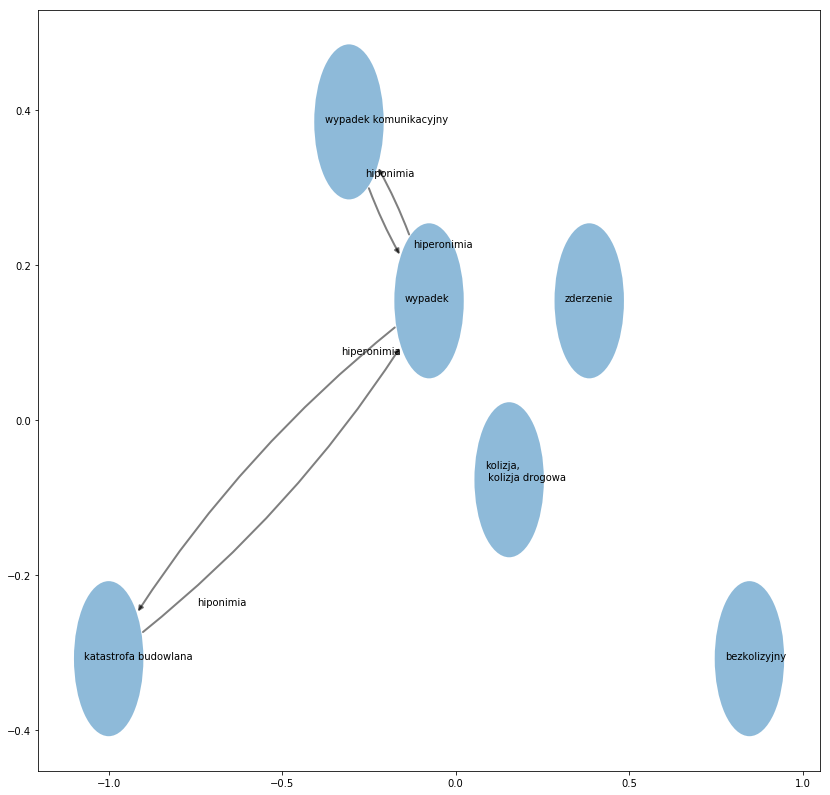

In [41]:
h2,labels2= graph_and_labels(synset_ids2,relations2,synsets2)

fig = plt.figure()
fig.set_size_inches(14,14)
ax= plt.gca()

pos2 = nx.planar_layout(h2)
draw_network(h2,pos2,ax,labels2)
ax.autoscale()
# plt.show()

In [42]:
h3,labels3= graph_and_labels(seq(allowed_nodes),relation3,synsets3) #TODO:bcm - doestn work exactly
allowed_nodes == synsets3.map(_.id).to_set()

True

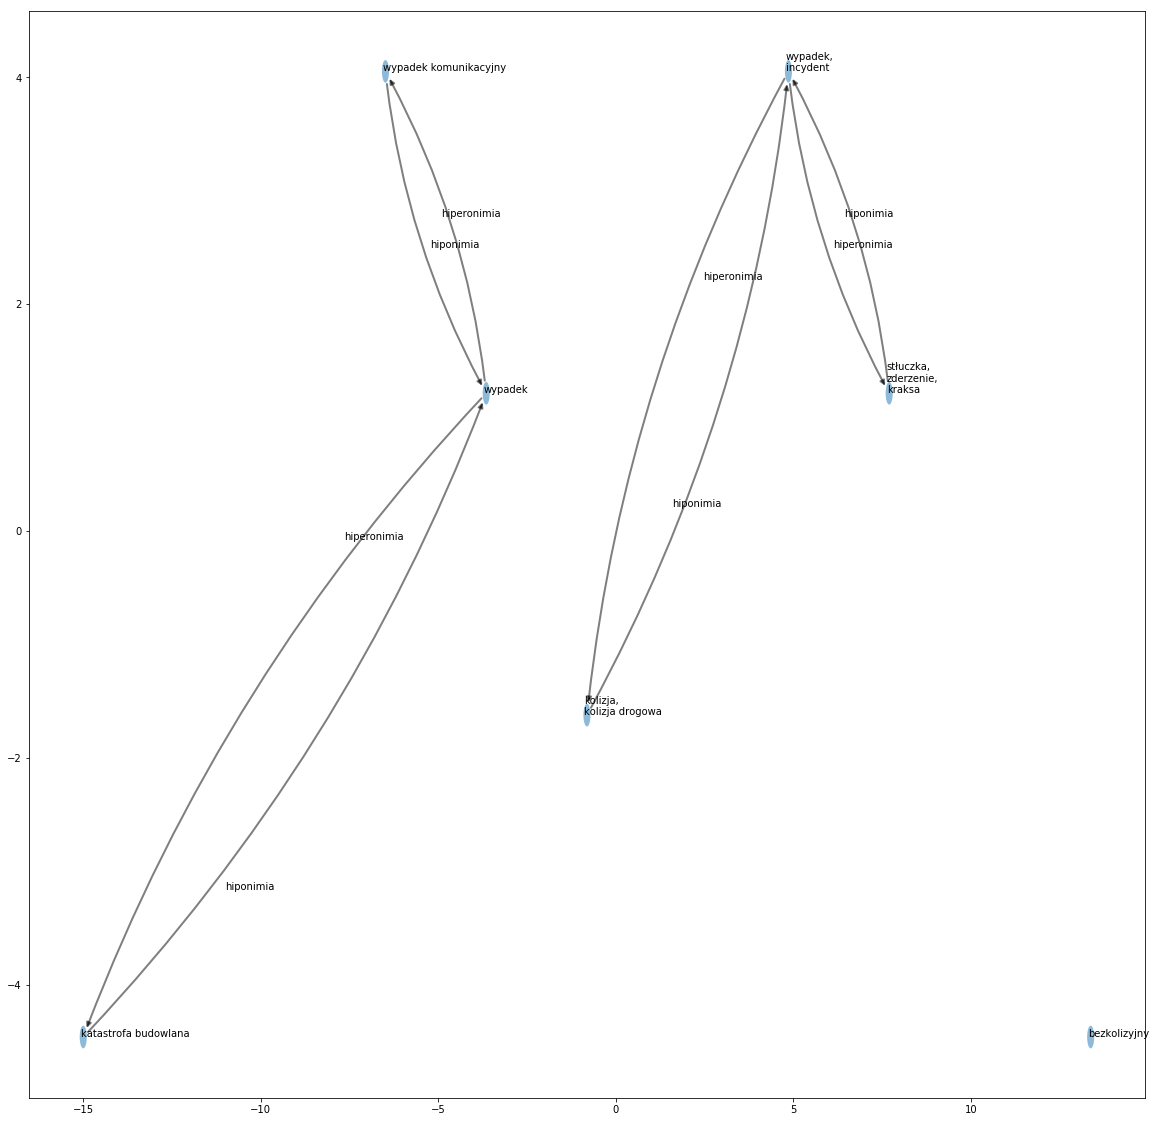

In [43]:
%matplotlib inline
fig = plt.figure()
fig.set_size_inches(20,20)
ax= plt.gca()

pos3 = nx.planar_layout(h3,scale=15)

draw_network(h3,pos3,ax,labels3)
ax.autoscale()
plt.show()

Wypadek on the top has been discovered as intermediate node. Maybe there could be found another connection using third degree relations.

In [44]:
from copy import deepcopy
bezkolizyjny = 228740

other = deepcopy(allowed_nodes)
other.remove(bezkolizyjny)

# todo: move to inner


def bfs(source:int, targets:Set[int],rel_fun):
    visited = set()
    rels = set()
    go_on = True
    def bfs_inner(source:int):
        print(source)
        if source in targets:
            visited.add(source)
            return [source]
        elif go_on:
            visited.add(source)
            new_rels = rel_fun(source)
            rels.union(new_rels)
            new_sources = new_rels.flat_map(lambda rel: [rel.synset_from,rel.synset_to]).filter_not(lambda syn: syn in visited) #error here
            return new_sources.flat_map(lambda x: bfs_inner(x))
        else:
            return []
    return bfs_inner(source)
    
    
#excedees maximum recursion limit
# result = bfs(bezkolizyjny,other,synset_rel)
# result

## 8\. Find the value of [Leacock-Chodorow semantic similarity measure](ftp://www-vhost.cs.toronto.edu/public_html/public_html/pub/gh/Budanitsky+Hirst-2001.pdf)
   between following pairs of lexemes:
   1. szkoda<sub>2</sub> - wypadek<sub>1</sub>,
   1. kolizja<sub>2</sub> - szkoda majątkowa<sub>1</sub>,
   1. nieszczęście<sub>2</sub> - katastrofa budowlana<sub>1</sub>.

In [45]:
def synset_id_for_word(word,sense_nr):
    return synsetid_for_sense(senses_search(word).find(lambda x: x['senseNumber']==sense_nr)['id'])

In [71]:
@lru_cache()
def synset_rel_to(synset:int,rel:Optional[int]=None, direction_to = True)-> Sequence:
    suffix = 'to' if direction_to else 'from'
    body = r.get(base+"/synsets/{}/relations/{}".format(synset,suffix)).json()
    
    
    def ala(x):
        return Relation(src = x['synsetFrom']['id']
                     ,dst = x['synsetTo']['id']
                     ,rel_id = x['relation']['id'])
    result = seq(body)\
        .map(ala)
        
    if rel is None:
        return result
    else:
        return result\
        .filter(_.rel_id == rel) 
   
# as before but this one is better - saves relations
def all_parents(synset_id:int,direction_to:bool=True):
    mapper = (lambda x : x.src) if direction_to else (lambda x:x.dst)
    relations = []
    processed_syns =[] 
    def process(syn):
        parent_rels = synset_rel_to(syn,11,direction_to)
        ala = parent_rels.to_list()
        
        relations.extend(ala)
        processed_syns.append(syn)
        
        if parent_rels.size() != 0:
            parent_rels.map(mapper).filter(lambda x : x not in processed_syns).for_each(process)
    process(synset_id)
    return (processed_syns,relations)

In [72]:
def distance(parents1,parents2):
    common_parent,index1= seq(parents1).zip_with_index().find(lambda t: t[0] in parents2)
    _, index2 = seq(parents2).zip_with_index().find(lambda t: t[0] == common_parent)
    return index1+index2
    

In [73]:
def lch_for_dist(dist:float)-> float:
    #https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.221.2672&rep=rep1&type=pdf
    max_depth = 11 # for plWordNet 1.0 at least according to publication above
    return -math.log((dist + 1) / (2.0 * max_depth))

In [74]:
def lch (synset_1:int,synset_2:int ) -> float:
    parents1 ,_= all_parents(synset_1,True)
    parents2 ,_= all_parents(synset_2,True)
    dist = distance(parents1,parents2)
    return lch_for_dist(dist)

In [75]:
syn1,syn2 = synset_id_for_word("szkoda",2),synset_id_for_word("wypadek",1)
lch(syn1,syn2)


1.7047480922384253

In [76]:
#syn1,syn2 = synset_id_for_word("kolizja",2),synset_id_for_word("szkoda majątkowa",1) #TODO
#lch(syn1, syn2)

In [77]:
syn1,syn2 = synset_id_for_word("nieszczęście",2),synset_id_for_word("katastrofa budowlana",1)
# lch(syn1, syn2) # TODO:bcm - wrong
all_parents(syn1)

([5640, 31390, 18122, 1133, 102970, 323, 26983, 5540],
 [Relation(src=31390, dst=5640, rel_id=11),
  Relation(src=18122, dst=31390, rel_id=11),
  Relation(src=26983, dst=31390, rel_id=11),
  Relation(src=1133, dst=18122, rel_id=11),
  Relation(src=102970, dst=1133, rel_id=11),
  Relation(src=323, dst=102970, rel_id=11),
  Relation(src=5540, dst=26983, rel_id=11)])

In [80]:
all_parents(syn2)# TODO: present different similarities and recover failing ones with defaults from nltk

([411618, 3982, 27419, 6526],
 [Relation(src=3982, dst=411618, rel_id=11),
  Relation(src=27419, dst=3982, rel_id=11),
  Relation(src=6526, dst=27419, rel_id=11)])